## Relativistic SGHMC "Relativistic Monte Carlo"

In this notebook we reproduce the results of the paper 
[Relativistic Monte Carlo](http://proceedings.mlr.press/v54/lu17b/lu17b.pdf#page=7).

We start by introducing and plotting all relevant log likelihoods of our objective functions.

In [17]:
%matplotlib inline
import sys
import os
sys.path.insert(0, os.path.join(os.path.abspath("."), "..", "..", ".."))

from pysgmcmc.diagnostics.sample_chains import PYSGMCMCTrace
from pymc3.backends.base import MultiTrace
from pymc3.diagnostics import effective_n as ess

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler

from pysgmcmc.diagnostics.objective_functions import (
    banana_log_likelihood,
    gmm1_log_likelihood, gmm2_log_likelihood,
    gmm3_log_likelihood
)

from collections import namedtuple

ObjectiveFunction = namedtuple(
    "ObjectiveFunction", ["function", "dimensionality"]
)

objective_functions = (
    ObjectiveFunction(
        function=banana_log_likelihood, dimensionality=2
    ),
    ObjectiveFunction(
        function=gmm1_log_likelihood, dimensionality=1
    ),
    ObjectiveFunction(
        function=gmm2_log_likelihood, dimensionality=1
    ),
    ObjectiveFunction(
        function=gmm3_log_likelihood, dimensionality=1
    ),
)


def cost_function(log_likelihood_function):
    def wrapped(*args, **kwargs):
        return -log_likelihood_function(*args, **kwargs)
    wrapped.__name__ = log_likelihood_function.__name__
    return wrapped

#  Banana Contour {{{ #
def banana_plot():
    #x = np.arange(-30, 30, 0.05)
    #y = np.arange(-60, 20, 0.05)
    x = np.arange(-25, 25, 0.05)
    y = np.arange(-50, 20, 0.05)
    xx, yy = np.meshgrid(x, y, sparse=True)
    densities = np.asarray([np.exp(banana_log_likelihood((x, y))) for x in xx for y in yy])
    f, ax = plt.subplots(1)
    xdata = [1, 4, 8]
    ydata = [10, 20, 30]
    ax.contour(x, y, densities, 1, label="Banana")
    ax.plot([], [], label="Banana")
    ax.legend()
    ax.grid()
    #ax.set_ylim(ymin=-10, ymax=40)
    #ax.set_xlim(xmin=-6, xmax=7)
    ax.set_ylim(ymin=-60, ymax=20)
    ax.set_xlim(xmin=-30, xmax=30)
    
#  }}} Banana Contour #

#  Gaussian Mixture Models {{{ #

def gmm_plot(gmm_fun, label=None):
    xv = np.arange(-10, 10, 0.1)
    yv = np.asarray([np.exp(gmm_fun(xi)) for xi in xv])
    plt.grid()
    plt.plot(xv, yv, label=label)
    plt.legend()

plot_functions = {
    "banana_log_likelihood": banana_plot,
    "gmm1_log_likelihood": lambda: gmm_plot(gmm1_log_likelihood, label="GMM_1"),
    "gmm2_log_likelihood": lambda: gmm_plot(gmm2_log_likelihood, label="GMM_2"),
    "gmm3_log_likelihood": lambda: gmm_plot(gmm3_log_likelihood, label="GMM_3"),
}


def extract_samples(sampler, n_samples=1000, keep_every=10):
    from itertools import islice
    n_iterations = n_samples * keep_every
    return np.asarray(
        [sample for sample, _ in
         islice(sampler, 0, n_iterations, keep_every)]
    )

def plot_samples(sampler, n_samples=1000, keep_every=10):
    samples = extract_samples(
        sampler, n_samples=n_samples, keep_every=keep_every
    )
    plot_functions[sampler.cost_fun.__name__]()
    
    first_sample = samples[0]
    try:
        sample_dimensionality, = first_sample.shape
    except ValueError:
        plt.scatter(samples, np.exp([-sampler.cost_fun(sample) for sample in samples]))
    else:
        plt.scatter(*[samples[:, i] for i in range(sample_dimensionality)])

### Extract samples and plot them

Below we extract $1000$ samples for each cost function using relativistic sghmc and plot the samples on top of the respective function.

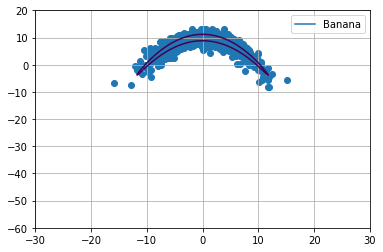

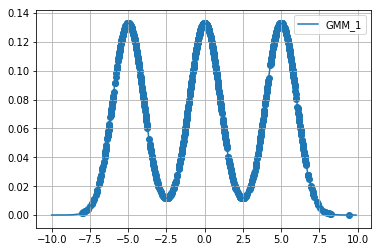

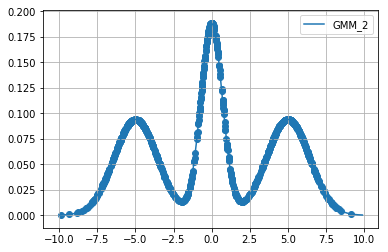

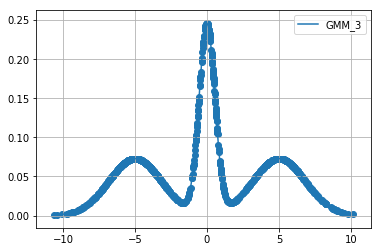

In [18]:
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.stepsize_schedules import ConstantStepsizeSchedule

for function, dimensionality in objective_functions:
    tf.reset_default_graph()
    graph = tf.Graph()
    
    with tf.Session(graph=graph) as session:
        if function.__name__ == "banana_log_likelihood":
            params = [
                tf.Variable(0., dtype=tf.float32, name="x"), 
                tf.Variable(6., dtype=tf.float32, name="y")
            ]
        else:
            params = [tf.Variable(0., dtype=tf.float32, name="x")]
        sampler = RelativisticSGHMCSampler(
            stepsize_schedule=ConstantStepsizeSchedule(1.5),
            params=params, 
            cost_fun=cost_function(function), 
            session=session,
            dtype=tf.float32
        )
        session.run(tf.global_variables_initializer())
    
        plot_samples(sampler)
        plt.show()

### Diagnostics

Next, we analyze some diagnostics of our relativistic sghmc sampler. Namely, we will study how effective sample sizes (ESS) and mean absolute error (MAE) behave and vary over different values for the stepsize $\epsilon$.


In [ ]:
# NBVAL_SKIP
# this runs for a long time, so we do *not* want to run this on every travis-build

stepsizes = np.arange(0.01, 3.1, 0.1)  # vary stepsize over grid

for function, dimensionality in objective_functions:

    ess_vals = []

    for stepsize in stepsizes:

        tf.reset_default_graph()
        graph = tf.Graph()

        with tf.Session(graph=graph) as session:
            if function.__name__ == "banana_log_likelihood":
                params = [
                    tf.Variable(0., dtype=tf.float32, name="x"),
                    tf.Variable(6., dtype=tf.float32, name="y")
                ]
            else:
                params = [tf.Variable(0., dtype=tf.float32, name="x")]

            sampler = RelativisticSGHMCSampler(
                stepsize_schedule=ConstantStepsizeSchedule(stepsize),
                params=params,
                cost_fun=cost_function(function),
                session=session,
                dtype=tf.float32
            )
            session.run(tf.global_variables_initializer())

            n_chains = 20

            traces = []

            for chain_id in range(n_chains):
                samples = extract_samples(sampler, n_samples=10 ** 4, keep_every=10)
                single_trace = PYSGMCMCTrace(
                    chain_id=chain_id, samples=samples, varnames=["x", "y"]
                )
                traces.append(single_trace)
            multi_trace = MultiTrace(traces)

            mean_ess = np.mean(list(ess(multi_trace).values()))

            ess_vals.append(mean_ess)

    plt.plot(stepsizes, ess_vals)
    plt.show()